# all imports

In [1]:
import torch
from torch import nn, optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# parameters

In [3]:
# Choose subset of parts to train
keep_parts = slice(10)

epochs = 300 # ctrl-c to stop early
lr = 0.001

seq_len = 50
batch_size = 2

# Increase hidden_dim depending on number of parts being trained
# since it encodes forecast for all parts
hidden_dim = 512
layers = 2

# How many weeks to forecast
predict_steps = 50
# Forecast starts immediately after this slice of data
predict_input = slice(-predict_steps//2)

In [4]:
array = pd.read_csv("order-data.csv", skiprows=[0]).to_numpy()[keep_parts]

# test with sin wave

In [5]:
# Uncomment cell to test predicting sin waves to make sure everything is working...
# epochs = 10000
# lr = .001
# seq_len = 150
# batch_size = 1
# hidden_dim = 128
# layers = 2
# predict_steps = 100
# predict_input = slice(-seq_len, None)
# # Sequence needs to see at least a full wave length or results are bad
# array = np.array([[f'Wave {i}']+[np.sin(x + i*2*np.pi/2)*(i+1) for x in np.linspace(-1000, 1000, 10051)] for i in range(2)])

# transpose data
Extract part name from first column.  Transpose data so each column holds the quantities for a part.

In [6]:
part_names = array.T[0]
floats = np.array(array.T[1:], dtype='float32')
floats.shape

(104, 10)

# normalize quantities to be 0 - 1

In [7]:
min_ = floats.min(0)
max_ = floats.max(0)
normalize   = lambda values: (values - min_) / (max_ - min_)
unnormalize = lambda normalized: normalized * (max_ - min_) + min_

tensor = torch.from_numpy(normalize(floats))

# batch data
Notice how the columns line up. The hidden state output from 0,1,2,3,4 gets fed into sequence 5,6,7,8,9

In [8]:
def batch_data(items, seq_len, batch_size):
    num_batches = (len(items)-1) // (seq_len * batch_size)
    keep = num_batches*seq_len*batch_size
    discard = len(items) - keep - 1
    if discard: print(f"Discarding last {discard} items")
    features = items[:keep]   .view(batch_size, num_batches, seq_len, -1).transpose(0,1).transpose(1,2).to(device)
    targets  = items[1:keep+1].view(batch_size, num_batches, seq_len, -1).transpose(0,1).transpose(1,2).to(device)
    return [*zip(features, targets)]

for x, target in batch_data(torch.tensor(range(31)), seq_len=5, batch_size=3):
    print(x[:,:,0])

tensor([[ 0, 10, 20],
        [ 1, 11, 21],
        [ 2, 12, 22],
        [ 3, 13, 23],
        [ 4, 14, 24]])
tensor([[ 5, 15, 25],
        [ 6, 16, 26],
        [ 7, 17, 27],
        [ 8, 18, 28],
        [ 9, 19, 29]])


In [9]:
# split = int(tensor.shape[0] * .8)
# train = batch_data(tensor[:split], seq_len, batch_size)
# valid = batch_data(tensor[split:], seq_len, batch_size)

# Until we get more data...
train = valid = batch_data(tensor, seq_len, batch_size)

Discarding last 3 items


# create RNN model
Using LSTM but GRU might be better

In [10]:
class RNN(nn.Module):

    def __init__(self, input_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, layers, dropout=.3)
        self.fc = nn.Linear(hidden_dim, input_dim)
        self.dropout = nn.Dropout(.3)

    def forward(self, x, hidden):
        y, hidden = self.lstm(x, hidden)
        y = y.view(-1, hidden_dim)
        y = self.dropout(y)
        y = self.fc(y)
        return y.view(x.shape), hidden

# define loss and optimizer

In [11]:
model = RNN(tensor.shape[-1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# train
Kernal -> Interrupt to end training early

In [12]:
for epoch in range(epochs):
    model.train()
    train_loss = 0
    hidden = None
    for x, target in train:
        if hidden:
            hidden = tuple(h.detach() for h in hidden)

        y, hidden = model(x, hidden)
        loss = criterion(y, target)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        valid_loss = 0
        hidden = None
        for x, target in valid:
            y, hidden = model(x, hidden)
            loss = criterion(y, target)
            valid_loss += loss.item()

    print(f"Epoc {epoch}",
          f"train_loss={round(train_loss*1e5/len(train))}",
          f"valid_loss={round(valid_loss*1e5/len(valid))}")

Epoc 0 train_loss=2184 valid_loss=1890
Epoc 1 train_loss=1905 valid_loss=1934
Epoc 2 train_loss=1938 valid_loss=1878
Epoc 3 train_loss=1866 valid_loss=1854
Epoc 4 train_loss=1863 valid_loss=1855
Epoc 5 train_loss=1852 valid_loss=1857
Epoc 6 train_loss=1855 valid_loss=1852
Epoc 7 train_loss=1859 valid_loss=1842
Epoc 8 train_loss=1841 valid_loss=1830
Epoc 9 train_loss=1830 valid_loss=1819
Epoc 10 train_loss=1826 valid_loss=1809
Epoc 11 train_loss=1816 valid_loss=1801
Epoc 12 train_loss=1809 valid_loss=1792
Epoc 13 train_loss=1782 valid_loss=1782
Epoc 14 train_loss=1787 valid_loss=1768
Epoc 15 train_loss=1768 valid_loss=1752
Epoc 16 train_loss=1758 valid_loss=1733
Epoc 17 train_loss=1730 valid_loss=1712
Epoc 18 train_loss=1725 valid_loss=1689
Epoc 19 train_loss=1700 valid_loss=1664
Epoc 20 train_loss=1677 valid_loss=1635
Epoc 21 train_loss=1651 valid_loss=1601
Epoc 22 train_loss=1608 valid_loss=1563
Epoc 23 train_loss=1568 valid_loss=1522
Epoc 24 train_loss=1543 valid_loss=1479
Epoc 25 tr

Epoc 210 train_loss=263 valid_loss=220
Epoc 211 train_loss=251 valid_loss=227
Epoc 212 train_loss=257 valid_loss=223
Epoc 213 train_loss=257 valid_loss=221
Epoc 214 train_loss=274 valid_loss=221
Epoc 215 train_loss=252 valid_loss=218
Epoc 216 train_loss=244 valid_loss=222
Epoc 217 train_loss=266 valid_loss=225
Epoc 218 train_loss=268 valid_loss=244
Epoc 219 train_loss=308 valid_loss=227
Epoc 220 train_loss=308 valid_loss=226
Epoc 221 train_loss=254 valid_loss=211
Epoc 222 train_loss=249 valid_loss=240
Epoc 223 train_loss=267 valid_loss=225
Epoc 224 train_loss=274 valid_loss=206
Epoc 225 train_loss=240 valid_loss=236
Epoc 226 train_loss=277 valid_loss=220
Epoc 227 train_loss=258 valid_loss=236
Epoc 228 train_loss=272 valid_loss=227
Epoc 229 train_loss=286 valid_loss=234
Epoc 230 train_loss=252 valid_loss=215
Epoc 231 train_loss=256 valid_loss=209
Epoc 232 train_loss=235 valid_loss=234
Epoc 233 train_loss=296 valid_loss=194
Epoc 234 train_loss=241 valid_loss=242
Epoc 235 train_loss=323 v

# run data through model to create hidden state then generate predictions

In [13]:
input = tensor[predict_input]
sequence = batch_data(input, len(input)-1, 1)
model.eval()
with torch.no_grad():
    x, _ = sequence[0]
    y, hidden = model(x, None)
    y = y[-1:, :, :]
    predict = [y[0,0,:]]
    for i in range(predict_steps):
        y, hidden = model(y, hidden)
        predict.append(y[0,0,:])

# unnormalize data

In [14]:
actual = tensor[predict_input.start:, :]
actual = unnormalize(actual.numpy())
predict = torch.stack(predict)
predict = unnormalize(predict.numpy())
predict[:,0]

array([ 1.5507669e+00,  3.2382724e+00, -3.0708385e+00,  2.1293909e+01,
       -2.0777946e+00, -3.5781367e+00, -6.4762032e-01,  3.8431046e+01,
        5.6377058e+00,  1.5759834e+00,  5.2574778e+00, -5.9208350e+00,
        1.4392511e+01,  3.6333391e-01,  1.2398185e+00, -3.1236062e+00,
        2.3129248e+01, -1.5175729e+00,  1.1084253e+00,  2.4614374e-01,
       -2.8629205e+00, -1.2128899e+00,  8.6681879e-01,  1.7209427e+00,
       -6.8541160e+00, -7.9483094e+00, -5.0102663e+00, -4.1881526e-01,
       -4.9308891e+00, -4.5410304e+00, -1.2265207e+01, -4.0938254e-02,
       -6.7863029e-01, -1.2430930e+01, -2.2976164e+01, -3.1025442e-01,
        8.8419116e-01, -1.1368727e+01, -2.8514122e+01, -1.3073984e+01,
       -3.3581958e+00, -1.1447991e+01, -3.1799723e+01, -3.2330090e+01,
       -7.6099796e+00, -1.0367833e+01, -3.1020235e+01, -4.8972649e+01,
       -2.2372181e+01, -1.7427303e+01, -3.2840080e+01], dtype=float32)

# generate plots

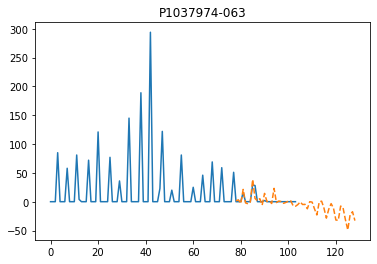

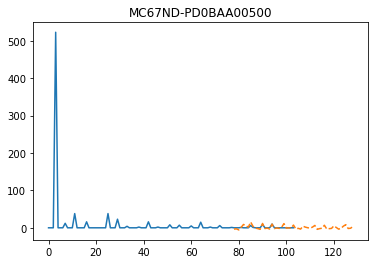

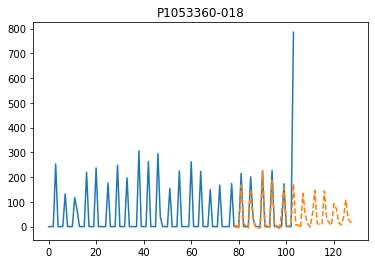

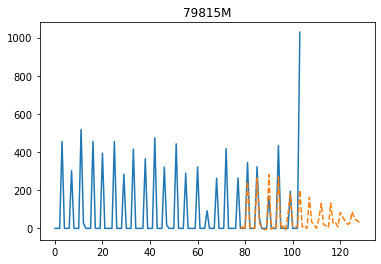

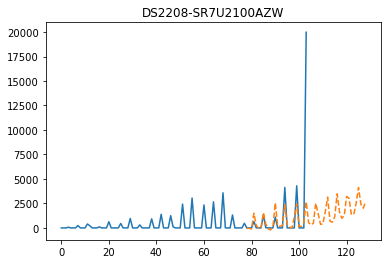

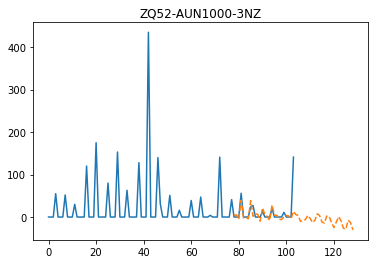

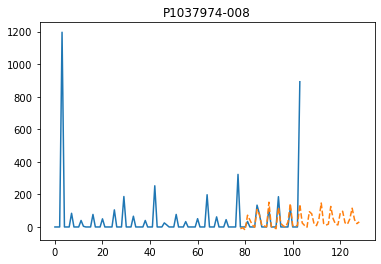

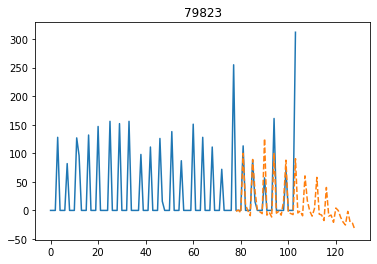

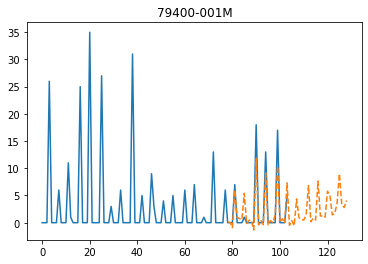

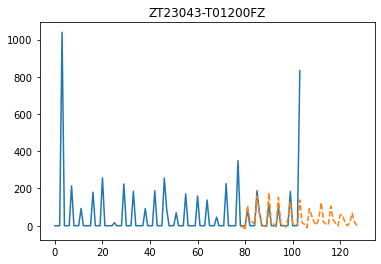

In [15]:
for p in range(actual.shape[1]):
    plt.title(part_names[p])
    act = actual[:, p]
    plt.plot(range(len(act)), act)
    pred = predict[:, p]
    plt.plot(range(len(x), len(x) + len(pred)), pred, linestyle='--')
    plt.show()